# GPU

In [1]:
#@title Titre par défaut
import numpy as np
np.random.seed(1000)


import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


import tensorflow as tf
import timeit

Found GPU at: /device:GPU:0


# Import

In [2]:
#@title Titre par défaut
import numpy as np
np.random.seed(1000)
import tensorflow as tf
import timeit
# https://keras.io/
!pip install -q keras
import keras

!pip install -q tqdm
import tqdm

Using TensorFlow backend.


In [0]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.optimizers import Adam, Adagrad
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.monitor_interval = 0

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D, MaxPooling2D
from keras.datasets import mnist
from keras.optimizers import Adam, Adagrad
from keras import backend as K
from keras import initializers
from keras.utils import np_utils

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('tf')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100
K.set_image_dim_ordering('th')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100


# RBF

In [0]:
from keras.engine import InputSpec, Layer
from keras.legacy import interfaces
#@title COUCHES RBF
###________TROIS CLASSES POUR IMPLEMENTER DES COUCHES RBF________###

class RBFLayer(Layer):
    def __init__(self, alpha=1000.0, alpha_initializer='zeros',
                 alpha_regularizer=None,
                 alpha_constraint=None, 
                 **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.supports_masking = True
        self.supports_masking = True
        self.alpha_initializer = keras.initializers.Constant(value=1000.0)
        self.alpha_regularizer = regularizers.get(alpha_regularizer)
        self.alpha_constraint = constraints.get(alpha_constraint)
        self.alpha = self.add_weight(shape=(1,),
                                     name='alpha',
                                     initializer=self.alpha_initializer,
                                     regularizer=self.alpha_regularizer,
                                     constraint=self.alpha_constraint)
        self.trainable = False

    def call(self, inputs):
        y = - inputs / self.alpha[0]
        y = keras.backend.exp(y)
        return y

    def get_config(self):
        config = {
            'alpha_initializer': initializers.serialize(self.alpha_initializer),
            'alpha_regularizer': regularizers.serialize(self.alpha_regularizer),
            'alpha_constraint': constraints.serialize(self.alpha_constraint),
            'shared_axes': self.shared_axes
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

class RBF(Layer):
    @interfaces.legacy_dense_support
    def __init__(self, units,
                 activation=None,
                 use_bias=False,
                 kernel_initializer='TruncatedNormal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 sigma = 1000.0,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(RBF, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.sigma = sigma
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def call(self, inputs):
        norm_x = K.transpose(K.sum(inputs * inputs , axis=1))
        norm_w = K.sum(self.kernel *self.kernel , axis=0)
        norm_x = keras.backend.expand_dims(norm_x, axis=-1)
        prod_scal = -2 * K.dot(inputs, self.kernel)
        print ("Shapes : ", norm_x.shape, norm_w.shape, prod_scal.shape) 
        a = tf.add(norm_x, prod_scal) # -2 *  prod_scal)
        y = tf.add(a, norm_w )
        y = - y / self.sigma
        y = keras.backend.exp(y)
        return y

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(RBF, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class RBF2(Layer):
    @interfaces.legacy_dense_support
    def __init__(self, units,
                 activation=None,
                 use_bias=False,
                 kernel_initializer='TruncatedNormal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(RBF2, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def call(self, inputs):
        norm_x = K.transpose(K.sum(inputs * inputs , axis=1))
        norm_w = K.sum(self.kernel *self.kernel , axis=0)
        norm_x = keras.backend.expand_dims(norm_x, axis=-1)
        prod_scal = -2 * K.dot(inputs, self.kernel)
        print ("Shapes : ", norm_x.shape, norm_w.shape, prod_scal.shape) 
        a = tf.add(norm_x, prod_scal) # -2 *  prod_scal)
        y = tf.add(a, norm_w )
        return y

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(RBF2, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# Base de données selon un seuil

In [0]:


# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the file
downloaded = drive.CreateFile({'id':'1eyJdoywF4ZLygiQCrC-xfFVPXWr3wRDc'}) # replace the id with id of file you want to access
downloaded.GetContentFile('dossier1.csv')  

#3. Read file as panda dataframe
import pandas as pd
dossier1 = pd.read_csv('dossier1.csv') 

In [0]:
seuil=0.3
good_examples=dossier1[(dossier1.resultat<seuil)]

good_examples=good_examples.drop(['resultat'],axis=1)

In [9]:
good_examples=good_examples.reset_index()
#good_examples=good_examples.drop(['level_0'],axis=1)
good_examples=good_examples.drop(['index'],axis=1)
good_examples.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,-0.993655,-0.999728,-0.999991,-0.999994,-0.999993,-0.999983,-0.999883,-0.999748,-0.999642,-0.999962,...,-0.999999,-0.999997,-0.999996,-0.999989,-0.999970,-0.999978,-0.999960,-0.999968,-0.999824,-0.998089
1,-0.995718,-0.999480,-0.999966,-0.999962,-0.999973,-0.999966,-0.999844,-0.999784,-0.998754,-0.996572,...,-0.999995,-0.999973,-0.999977,-0.999977,-0.999973,-0.999960,-0.999937,-0.999974,-0.999878,-0.998335
2,-0.993488,-0.999659,-0.999989,-0.999994,-0.999988,-0.999987,-0.999989,-0.999995,-0.999999,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-0.999998,-0.999999,-0.999997,-0.999992,-0.999945,-0.997404
3,-0.991162,-0.999045,-0.999901,-0.999861,-0.999401,-0.999201,-0.998934,-0.999742,-0.999971,-0.999990,...,-0.999784,-0.999801,-0.999927,-0.999989,-0.999989,-0.999989,-0.999980,-0.999912,-0.999274,-0.993986
4,-0.998318,-0.999619,-0.999882,-0.999874,-0.999692,-0.999711,-0.999747,-0.999784,-0.999935,-0.999973,...,-0.999582,-0.999862,-0.999953,-0.999999,-0.999999,-0.999997,-0.999992,-0.999977,-0.999844,-0.999246


In [0]:
good_examples['target']=0.9

In [0]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_test = (X_test.astype(np.float32) - 127.5)/127.5



In [0]:
xyz=pd.DataFrame(X_train.reshape(60000,28*28))


In [0]:
xyz['target']=0


In [17]:
good_examples.shape

(13145, 785)

In [0]:
xyz.columns=good_examples.columns

In [0]:
xyz=pd.concat([xyz,good_examples],axis=0)

In [0]:
from sklearn.utils import shuffle
xyz=shuffle(xyz)

In [21]:
xyz.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,target
15665,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.00000,0.0
6671,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.00000,0.0
27193,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.00000,0.0
19591,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.00000,0.0
8763,-0.999779,-0.999442,-0.99985,-0.999964,-0.989169,-0.999981,-0.9997,-0.999665,-0.995995,-0.996644,...,-0.999983,-0.999773,-0.992704,-0.995544,-0.990925,-0.999717,-0.999728,-0.99995,-0.99972,0.9


# rejector with 1 output

In [0]:
K.set_image_dim_ordering('tf')


In [0]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

nb_classes = 10
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, :, :, np.newaxis]

Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_train = Y_train * 0.9

X_test = (X_test.astype(np.float32) - 127.5)/127.5
X_test = X_test[:, :, :,np.newaxis ]
Y_test = np_utils.to_categorical(y_test, nb_classes)
#Y_test = Y_test * 0.9

In [24]:
########################################"True"
from keras import activations, initializers, regularizers, constraints,metrics
from keras.optimizers import Adam, Adagrad
adagrad = Adagrad(lr=0.001, epsilon=None, decay=0.0) #c'est celui-là qui est utilisé pour tous les modèles


# Rejector
rejector= Sequential()
rejector.add(Conv2D(64, kernel_size=(3, 3), padding='same', input_shape=(28, 28,1),activation='relu'))
rejector.add(MaxPooling2D(pool_size=(3, 3)))
rejector.add(Conv2D(128, (3, 3), activation='relu') )
rejector.add(MaxPooling2D(pool_size=(3, 3)) )
rejector.add(Dropout(0.25))
rejector.add(Flatten())
rejector.add(Dense(128, activation='relu'))
rejector.add(RBF2(300) )
rejector.add(RBFLayer(alpha=2000.0) )
rejector.add(Dense(1, activation='sigmoid', name='r_output', use_bias=False))


rejector.compile(optimizer=adagrad, loss= 'mse', metrics=['acc'])  #  metrics=['acc', f1, precision, recall])
rejector.summary()

('Shapes : ', TensorShape([Dimension(None), Dimension(1)]), TensorShape([Dimension(300)]), TensorShape([Dimension(None), Dimension(300)]))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
___

In [0]:
from sklearn.model_selection import train_test_split
xyz_train,xyz_val=train_test_split(xyz,test_size=0.2)
y_train=xyz_train.target.values
x_train=xyz_train.drop(['target'],axis=1)
y_val=xyz_val.target.values
x_val=xyz_val.drop(['target'],axis=1)

In [0]:
x_train=x_train.values.astype('float32').reshape(x_train.shape[0],28,28,1)
x_val=x_val.values.astype('float32').reshape(x_val.shape[0],28,28,1)

In [27]:
from keras.callbacks import ReduceLROnPlateau
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

epochs = 50 
batch_size = 60
rejector.fit(x_train, y_train, nb_epoch=epochs, batch_size=batch_size, callbacks=[learning_rate_reduction],validation_data = (x_val, y_val))

/usr/local/lib/python2.7/dist-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 58516 samples, validate on 14629 samples
Epoch 1/50
58516/58516 [==============================] - 16s 280us/step - loss: 0.1154 - acc: 0.8201 - val_loss: 0.1084 - val_acc: 0.8210
Epoch 2/50
52740/58516 [==========================>...] - ETA: 1s - loss: 0.1042 - acc: 0.8205

58516/58516 [==============================] - 16s 270us/step - loss: 0.1038 - acc: 0.8201 - val_loss: 0.0989 - val_acc: 0.8210
Epoch 3/50
58516/58516 [==============================] - 16s 270us/step - loss: 0.0964 - acc: 0.8201 - val_loss: 0.0928 - val_acc: 0.8210
Epoch 4/50
27180/58516 [============>.................] - ETA: 7s - loss: 0.0919 - acc: 0.8218

58516/58516 [==============================] - 16s 270us/step - loss: 0.0917 - acc: 0.8201 - val_loss: 0.0884 - val_acc: 0.8210

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.000500000023749.
Epoch 5/50
58516/58516 [==============================] - 16s 271us/step - loss: 0.0892 - acc: 0.8201 - val_loss: 0.0871 - val_acc: 0.8210
Epoch 6/50
 7080/58516 [==>...........................] - ETA: 12s - loss: 0.0858 - acc: 0.8291

58516/58516 [==============================] - 16s 269us/step - loss: 0.0880 - acc: 0.8201 - val_loss: 0.0859 - val_acc: 0.8210
Epoch 7/50
58516/58516 [==============================] - 16s 269us/step - loss: 0.0869 - acc: 0.8201 - val_loss: 0.0848 - val_acc: 0.8210

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.000250000011874.
Epoch 8/50
13200/58516 [=====>........................] - ETA: 11s - loss: 0.0861 - acc: 0.8186

58516/58516 [==============================] - 16s 271us/step - loss: 0.0862 - acc: 0.8201 - val_loss: 0.0844 - val_acc: 0.8210
Epoch 9/50
58516/58516 [==============================] - 16s 271us/step - loss: 0.0856 - acc: 0.8201 - val_loss: 0.0840 - val_acc: 0.8210
Epoch 10/50
18000/58516 [========>.....................] - ETA: 10s - loss: 0.0852 - acc: 0.8208

58516/58516 [==============================] - 16s 271us/step - loss: 0.0853 - acc: 0.8201 - val_loss: 0.0837 - val_acc: 0.8210

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.000125000005937.
Epoch 11/50
58516/58516 [==============================] - 16s 269us/step - loss: 0.0852 - acc: 0.8201 - val_loss: 0.0835 - val_acc: 0.8210
Epoch 12/50
 5460/58516 [=>............................] - ETA: 13s - loss: 0.0810 - acc: 0.8300

58516/58516 [==============================] - 16s 270us/step - loss: 0.0849 - acc: 0.8201 - val_loss: 0.0833 - val_acc: 0.8210
Epoch 13/50
58516/58516 [==============================] - 16s 271us/step - loss: 0.0847 - acc: 0.8201 - val_loss: 0.0831 - val_acc: 0.8210

Epoch 00013: ReduceLROnPlateau reducing learning rate to 6.25000029686e-05.
Epoch 14/50
13140/58516 [=====>........................] - ETA: 11s - loss: 0.0870 - acc: 0.8146

58516/58516 [==============================] - 16s 271us/step - loss: 0.0846 - acc: 0.8201 - val_loss: 0.0831 - val_acc: 0.8210
Epoch 15/50
58516/58516 [==============================] - 16s 271us/step - loss: 0.0845 - acc: 0.8201 - val_loss: 0.0830 - val_acc: 0.8210
Epoch 16/50
17580/58516 [========>.....................] - ETA: 10s - loss: 0.0840 - acc: 0.8199

58516/58516 [==============================] - 16s 270us/step - loss: 0.0845 - acc: 0.8201 - val_loss: 0.0829 - val_acc: 0.8210

Epoch 00016: ReduceLROnPlateau reducing learning rate to 3.12500014843e-05.
Epoch 17/50
58516/58516 [==============================] - 17s 289us/step - loss: 0.0845 - acc: 0.8201 - val_loss: 0.0829 - val_acc: 0.8210
Epoch 18/50
 2820/58516 [>.............................] - ETA: 17s - loss: 0.0843 - acc: 0.8241

58516/58516 [==============================] - 20s 337us/step - loss: 0.0845 - acc: 0.8201 - val_loss: 0.0829 - val_acc: 0.8210
Epoch 19/50
58516/58516 [==============================] - 18s 314us/step - loss: 0.0844 - acc: 0.8201 - val_loss: 0.0829 - val_acc: 0.8210

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.56250007421e-05.
Epoch 20/50
 5040/58516 [=>............................] - ETA: 14s - loss: 0.0829 - acc: 0.8248

58516/58516 [==============================] - 16s 282us/step - loss: 0.0844 - acc: 0.8201 - val_loss: 0.0828 - val_acc: 0.8210
Epoch 21/50
58516/58516 [==============================] - 17s 289us/step - loss: 0.0843 - acc: 0.8201 - val_loss: 0.0828 - val_acc: 0.8210
Epoch 22/50
12960/58516 [=====>........................] - ETA: 11s - loss: 0.0834 - acc: 0.8220

58516/58516 [==============================] - 16s 270us/step - loss: 0.0843 - acc: 0.8201 - val_loss: 0.0828 - val_acc: 0.8210

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 23/50
58516/58516 [==============================] - 16s 270us/step - loss: 0.0843 - acc: 0.8201 - val_loss: 0.0828 - val_acc: 0.8210
Epoch 24/50
 6420/58516 [==>...........................] - ETA: 13s - loss: 0.0854 - acc: 0.8215

58516/58516 [==============================] - 16s 273us/step - loss: 0.0843 - acc: 0.8201 - val_loss: 0.0828 - val_acc: 0.8210
Epoch 25/50
58516/58516 [==============================] - 16s 271us/step - loss: 0.0843 - acc: 0.8201 - val_loss: 0.0828 - val_acc: 0.8210
Epoch 26/50
16080/58516 [=======>......................] - ETA: 10s - loss: 0.0846 - acc: 0.8182

58516/58516 [==============================] - 16s 270us/step - loss: 0.0842 - acc: 0.8201 - val_loss: 0.0828 - val_acc: 0.8210
Epoch 27/50
58516/58516 [==============================] - 16s 272us/step - loss: 0.0843 - acc: 0.8201 - val_loss: 0.0828 - val_acc: 0.8210
Epoch 28/50
18060/58516 [========>.....................] - ETA: 10s - loss: 0.0856 - acc: 0.8171

58516/58516 [==============================] - 16s 270us/step - loss: 0.0843 - acc: 0.8201 - val_loss: 0.0828 - val_acc: 0.8210
Epoch 29/50
58516/58516 [==============================] - 16s 268us/step - loss: 0.0844 - acc: 0.8201 - val_loss: 0.0828 - val_acc: 0.8210
Epoch 30/50
18840/58516 [========>.....................] - ETA: 9s - loss: 0.0850 - acc: 0.8200

58516/58516 [==============================] - 16s 269us/step - loss: 0.0843 - acc: 0.8201 - val_loss: 0.0827 - val_acc: 0.8210
Epoch 31/50
58516/58516 [==============================] - 16s 271us/step - loss: 0.0842 - acc: 0.8201 - val_loss: 0.0827 - val_acc: 0.8210
Epoch 32/50
19080/58516 [========>.....................] - ETA: 9s - loss: 0.0835 - acc: 0.8208

58516/58516 [==============================] - 16s 270us/step - loss: 0.0843 - acc: 0.8201 - val_loss: 0.0827 - val_acc: 0.8210
Epoch 33/50
58516/58516 [==============================] - 16s 272us/step - loss: 0.0843 - acc: 0.8201 - val_loss: 0.0827 - val_acc: 0.8210
Epoch 34/50
18840/58516 [========>.....................] - ETA: 9s - loss: 0.0833 - acc: 0.8231 

58516/58516 [==============================] - 16s 270us/step - loss: 0.0843 - acc: 0.8201 - val_loss: 0.0827 - val_acc: 0.8210
Epoch 35/50
58516/58516 [==============================] - 16s 271us/step - loss: 0.0843 - acc: 0.8201 - val_loss: 0.0827 - val_acc: 0.8210
Epoch 36/50
18780/58516 [========>.....................] - ETA: 9s - loss: 0.0829 - acc: 0.8219 

58516/58516 [==============================] - 16s 271us/step - loss: 0.0842 - acc: 0.8201 - val_loss: 0.0827 - val_acc: 0.8210
Epoch 37/50
58516/58516 [==============================] - 16s 272us/step - loss: 0.0843 - acc: 0.8201 - val_loss: 0.0827 - val_acc: 0.8210
Epoch 38/50
18480/58516 [========>.....................] - ETA: 10s - loss: 0.0854 - acc: 0.8174

58516/58516 [==============================] - 16s 271us/step - loss: 0.0840 - acc: 0.8201 - val_loss: 0.0827 - val_acc: 0.8210
Epoch 39/50
58516/58516 [==============================] - 16s 271us/step - loss: 0.0843 - acc: 0.8201 - val_loss: 0.0827 - val_acc: 0.8210
Epoch 40/50
19020/58516 [========>.....................] - ETA: 9s - loss: 0.0855 - acc: 0.8184

58516/58516 [==============================] - 16s 269us/step - loss: 0.0842 - acc: 0.8201 - val_loss: 0.0827 - val_acc: 0.8210
Epoch 41/50
58516/58516 [==============================] - 16s 271us/step - loss: 0.0842 - acc: 0.8201 - val_loss: 0.0827 - val_acc: 0.8210
Epoch 42/50
19080/58516 [========>.....................] - ETA: 9s - loss: 0.0831 - acc: 0.8216

58516/58516 [==============================] - 16s 270us/step - loss: 0.0842 - acc: 0.8201 - val_loss: 0.0827 - val_acc: 0.8210
Epoch 43/50
58516/58516 [==============================] - 16s 270us/step - loss: 0.0842 - acc: 0.8201 - val_loss: 0.0827 - val_acc: 0.8210
Epoch 44/50
19080/58516 [========>.....................] - ETA: 9s - loss: 0.0837 - acc: 0.8197

58516/58516 [==============================] - 16s 270us/step - loss: 0.0841 - acc: 0.8201 - val_loss: 0.0827 - val_acc: 0.8210
Epoch 45/50
58516/58516 [==============================] - 16s 271us/step - loss: 0.0841 - acc: 0.8201 - val_loss: 0.0827 - val_acc: 0.8210
Epoch 46/50
19200/58516 [========>.....................] - ETA: 9s - loss: 0.0834 - acc: 0.8209

58516/58516 [==============================] - 16s 270us/step - loss: 0.0841 - acc: 0.8201 - val_loss: 0.0826 - val_acc: 0.8210
Epoch 47/50
58516/58516 [==============================] - 16s 269us/step - loss: 0.0841 - acc: 0.8201 - val_loss: 0.0826 - val_acc: 0.8210
Epoch 48/50
18780/58516 [========>.....................] - ETA: 9s - loss: 0.0845 - acc: 0.8202 

58516/58516 [==============================] - 16s 270us/step - loss: 0.0842 - acc: 0.8201 - val_loss: 0.0826 - val_acc: 0.8210
Epoch 49/50
58516/58516 [==============================] - 16s 271us/step - loss: 0.0842 - acc: 0.8201 - val_loss: 0.0826 - val_acc: 0.8210
Epoch 50/50
18660/58516 [========>.....................] - ETA: 10s - loss: 0.0837 - acc: 0.8209

58516/58516 [==============================] - 16s 270us/step - loss: 0.0841 - acc: 0.8201 - val_loss: 0.0826 - val_acc: 0.8210


In [0]:
y_pred=rejector.predict(x_val)

In [0]:
Y_pred=[]
Y_val=[]
for i in range (y_pred.shape[0]):
  Y_pred.append(y_pred[i].item())
  if y_val[i].item() !=0:
    Y_val.append(1)
  else:
    Y_val.append(0)


In [0]:
from sklearn.metrics import roc_curve,auc
fpr,tpr,_=roc_curve(Y_val, Y_pred)
roc_auc=auc(fpr,tpr)

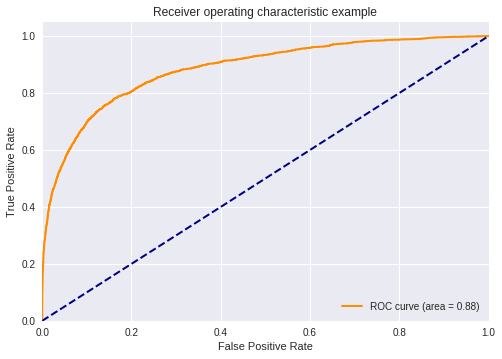

In [31]:
#seuil=0.3
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [0]:

y_rej_pred=rejector.predict(X_test)

In [33]:
max(y_rej_pred)

array([0.49502066], dtype=float32)

In [39]:
##### dessiner en fonction des seuil 
Point=[]
for j in range (1,500):
  Y_test_new=[]
  X_test_new=[]
  Y_rejet_new=[]
  X_rejet_new=[]

  for i in range(len (y_rej_pred)): 
    if y_rej_pred[i].item()<=float(j)/1000: 
      X_test_new.append(X_test[i,:,:,:])
      Y_test_new.append(y_test[i])  
    else:
      X_rejet_new.append(X_test[i,:,:,:])
      Y_rejet_new.append(y_test[i])  
    
  X_test_new=np.reshape(X_test_new, (len(X_test_new),28,28,1))
  X_rejet_new=np.reshape(X_rejet_new, (len(X_rejet_new),28,28,1))
  Y_rejet_new=np.array(Y_rejet_new)
  Y_test_new=np.array(Y_test_new)

  Y_test_new = np_utils.to_categorical(Y_test_new, 10)
  Y_rejet_new = np_utils.to_categorical(Y_rejet_new, 10)


  if Y_test_new.shape!=(0,):
    liste=model_95.evaluate(X_test_new,Y_test_new)
    if liste!=[]:
      Point.append((float(j)/100,liste[1]))
  
  #Point.append(liste[1])
  
  
 # l'AUC



704/874 [=======================>......] - ETA: 0s

2304/2328 [============================>.] - ETA: 0s

 512/3619 [===>..........................] - ETA: 0s

 768/4667 [===>..........................] - ETA: 0s

  32/5449 [..............................] - ETA: 1s

1792/6126 [=======>......................] - ETA: 0s

5440/6668 [=======================>......] - ETA: 0s

3328/7125 [=============>................] - ETA: 0s

1824/7508 [======>.......................] - ETA: 1s

7392/7833 [===========================>..] - ETA: 0s

6592/8118 [=======================>......] - ETA: 0s

5664/8325 [===================>..........] - ETA: 0s

4704/8527 [===============>..............] - ETA: 0s

3840/8730 [============>.................] - ETA: 1s

2592/8854 [=======>......................] - ETA: 1s

2592/8981 [=======>......................] - ETA: 1s

2336/9085 [======>.......................] - ETA: 1s

1536/9193 [====>.........................] - ETA: 1s

1568/9279 [====>.........................] - ETA: 1s

 800/9360 [=>............................] - ETA: 1s

 576/9433 [>.............................] - ETA: 1s

 288/9486 [..............................] - ETA: 1s

9408/9529 [============================>.] - ETA: 0s

 544/9576 [>.............................] - ETA: 1s

9088/9626 [===========================>..] - ETA: 0s

  32/9658 [..............................] - ETA: 1s

8960/9682 [==========================>...] - ETA: 0s

9711/9711 [==============================] - 2s 207us/step


9728/9742 [============================>.] - ETA: 0s

 320/9764 [..............................] - ETA: 1s

8960/9789 [==========================>...] - ETA: 0s

9816/9816 [==============================] - 2s 203us/step


8480/9841 [========================>.....] - ETA: 0s

9760/9856 [============================>.] - ETA: 0s

9600/9880 [============================>.] - ETA: 0s

9504/9892 [===========================>..] - ETA: 0s

9376/9906 [===========================>..] - ETA: 0s

9664/9917 [============================>.] - ETA: 0s

  32/9926 [..............................] - ETA: 2s

9184/9933 [==========================>...] - ETA: 0s

9940/9940 [==============================] - 2s 199us/step


9120/9949 [==========================>...] - ETA: 0s

9856/9958 [============================>.] - ETA: 0s

9888/9965 [============================>.] - ETA: 0s

9472/9973 [===========================>..] - ETA: 0s

  32/9980 [..............................] - ETA: 2s

9152/9984 [==========================>...] - ETA: 0s

 288/9990 [..............................] - ETA: 1s

9376/9996 [===========================>..] - ETA: 0s

  32/9998 [..............................] - ETA: 1s

10000/10000 [==============================] - 2s 200us/step


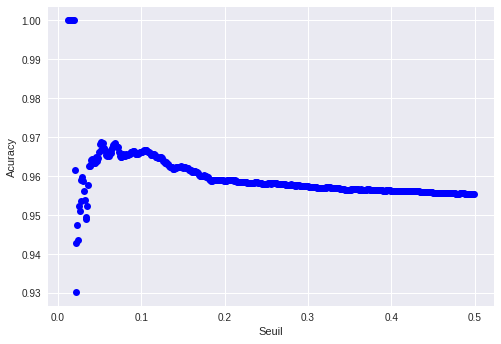

In [40]:
X=[]
Y=[]
for point in Point:
  X.append(point[0]/10)
  Y.append(point[1])
  
plt.xlabel("Seuil")
plt.ylabel("Acuracy")
plt.plot(X,Y,marker='o',color='b',ls='')
plt.show()

In [35]:
from google.colab import files
uploaded = files.upload()

Saving 10_classifier (1) to 10_classifier (1) (1)


In [36]:
model_95=keras.models.load_model('10_classifier (1)')